# 支持向量机(Support Vecor Machine, SVM)
<!--
Author: Zhaoqiang SHEN
Date: 2018/08/22
Contact: szqtclx@gmail.com
-->

支持向量机试图寻找一个距离两类数据都尽量远的平面来作为判定边界。

> **SVM 算法特点**  
> 优点：泛化错误率低，计算开销不大，结果易理解。  
> 缺点：对参数调节和核函数的选择敏感，原始分类器不加修改仅适合于处理二分类问题。  
> 使用数据类型：数值型和标称型数据。

In [1]:
import copy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import svm, linear_model

## 线性核支持向量分类器(SVC)

### 硬间隔SVC
对于一个线性可分的训练集，多个平面可以划分数据，只要它们满足：  
${\bf w}^T {\bf x}_i + b \geq +1$, for $y_i = +1$,  
${\bf w}^T {\bf x}_i + b \leq   -1$, for $y_i = -1$.

距离平面最近的两类训练样本称为**支持向量**（让上面两式之一等号成立的点），两异类支持向量到平面距离的和称为**几何间隔**，它等于$2/\|{\bf w} \|$。SVM希望在可以划分数据的平面中去找几何间隔最大者（也就是将最难分的点也尽量分得远一些）。  
因此SVM的**基本型**写为，  
优化目标：$\min_{{\bf w}, b} \frac{1}{2} \| {\bf w} \|^2$  
s.t. $y_i ({\bf w}^T {\bf x}_i+b) \geq 1$, for every $i=1,2,3, \cdots, m.$

利用拉格朗日乘子法，有$L({\bf w}, b, {\bf \alpha}) = \frac{1}{2} \| {\bf w} \|^2 + \sum_{i=1}^m \alpha_i (1-y_i ({\bf w}^T {\bf x}_i+b))$。   
当**强对偶性**成立时（Slater条件：对于凸函数，如果存在一个点使不等式约束严格成立，则满足强对偶性；对于非凸函数情况下通常不成立），主问题与对偶问题的解相等（否则后者小于前者），即$\min_{{\bf w}, b} \max_{\alpha_i} L({\bf w}, b, {\bf \alpha}) = \max_{\alpha_i} \min_{{\bf w}, b} L({\bf w}, b, {\bf \alpha})$，  
其中**对偶问题**为  
$RHS = \boxed {\max_{\alpha} \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_{i, j=1}^m \alpha_i \alpha_j y_i y_j {\bf x}_i^T {\bf x}_j }$,  
s.t. $\boxed {\sum_{i=1}^m \alpha_i y_i = 0}$, and $\boxed { \alpha_i \geq 0}$.

强对偶同样导致KKT条件成立，  
- stationarity: ${\bf w}=\sum_{i=1}^m \alpha_i y_i {\bf x}_i$, $\sum_{i=1}^m \alpha_i y_i = 0$;
- dual feasible: $\alpha_i \geq 0$;
- prime feasible: $1 - y_i ({\bf w}^T {\bf x}_i+b) \leq 0$;
- complementary slackness: $\alpha_i (1-y_i ({\bf w}^T {\bf x}_i+b)) = 0$.  

从KKT条件上来看，对于不在最大间隔边界上的点，其满足$y_i f({\bf x}_i)-1>0$，因此需要$\alpha_i=0$，它们也就对参数没有影响。事实上SVM只与支持向量相关。

### 软间隔SVC
当不能线性可分时（即存在不满足$y_i ({\bf w}^T {\bf x}_i + b) \geq 1$的样本点），我们希望不满足约束者越少越好。则优化目标改写为：  
$\min_{{\bf w}, b} \frac{1}{2} \| {\bf w} \|^2 + C \sum_{i=1}^m \ell(y_i ({\bf w}^T {\bf x}_i + b) )$  
其中，$C>0$为**惩罚参数**，它越大对不满足约束的点惩罚越重，当$C \to \infty$，软间隔SVC退化为硬间隔SVC；
损失函数$\ell$包括：
- 0/1 损失函数：$\ell_{0/1}(z) = H(-z)$;
- 合页(hinge)损失函数：$\ell_{hinge}(z) = \max(0, 1-z)$;
- 对数损失函数：$\ell_{exp}(z) = \exp(-z)$;
- 对率损失函数：$\ell_{log}(z) = \ln(1+\exp(-z))$.

对于合页损失函数，引入**松弛变量**$\xi_i = \ell_{hinge}(y_i ({\bf w}^T {\bf x}_i + b))$，则优化目标写为：  
$\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2} \| {\bf w} \|^2 + C \sum_{i=1}^m \xi_i$，  
其中，$ \xi_i \geq 0$ and $\xi_i \geq 1-y_i ({\bf w}^T {\bf x}_i + b)$。

得到拉格朗日函数：$L({\bf w}, b, {\bf \xi}, {\bf \alpha}, {\bf \mu}) = \frac{1}{2} \| {\bf w} \|^2 + C\sum_{i=1}^m \xi_i + \sum_{i=1}^m \alpha_i (1-\xi_i-y_i ({\bf w}^T {\bf x}_i+b)) - \sum_{i=1}^m \mu_i \xi_i$。  
它的对偶问题为：
$\max_{\alpha} \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_{i, j=1}^m \alpha_i \alpha_j y_i y_j {\bf x}_i^T {\bf x}_j $,  
s.t. $\sum_{i=1}^m \alpha_i y_i = 0$, and $\boxed {0 \leq \alpha_i \leq C}$.  

因为强对偶，所以KKT条件成立：  
- stationarity: ${\bf w}=\sum_{i=1}^m \alpha_i y_i {\bf x}_i$, $\sum_{i=1}^m \alpha_i y_i = 0$, $C=\alpha_i+\mu_i$;
- dual feasible: $\alpha_i \geq 0$, and $\mu_i \geq 0$;
- prime feasible: $1-\xi_i - y_i ({\bf w}^T {\bf x}_i+b) \leq 0$, and $-\xi_i \leq 0$;
- complementary slackness: $\alpha_i (1-\xi_i-y_i ({\bf w}^T {\bf x}_i+b))=0$, and $\mu_i \xi_i=0$.

由KKT条件可知，
1. 只有满足$1-\xi_i=y_i ({\bf w}^T {\bf x}_i+b)$的向量（支持向量）对参数有影响（落在最大间隔边界及内部的点），即合页损失函数保持了SVM的稀疏性。
2. 由于$\alpha_i+\mu_i=C$，如果某个点有$\alpha_i = C$，则$\mu_i=0$， $\xi_i \geq 0$，因此它可能落在最大间隔内部。如果$0 < \alpha_i < C$，则$\xi_i = 0$，它一定落在最大间隔边界上。

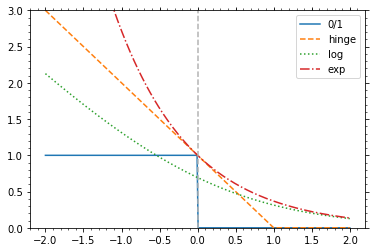

In [2]:
# Loss functions
fg0, ax0 = plt.subplots()

x = np.linspace(-2., 2., 300)
ax0.plot(x, x<0., ls='-', label='0/1')
ax0.plot(x, np.maximum(0., 1.-x), ls='--', label='hinge')
ax0.plot(x, np.log(1.+np.exp(-x)), ls=':', label='log')
ax0.plot(x, np.exp(-x), ls='-.', label='exp')

ax0.plot([0., 0.], [0., 3.], ls='--', c='0.7')
ax0.set_ylim((0., 3.))
ax0.legend()

### 求解SVC

上述对偶问题是二次规划问题，因此可以用常用的二次规划解法：椭球法(ellipsoid method)，内点法(interior method)，增广拉格朗日法(augmented Lagrangian)，梯度投影法(gradient projection)等。但这些方法运算规模正比于训练样本数，造成很大的运算开销。

#### 序列最小最优化算法(Sequential Minimal Optimization, SMO)
SMO算法[(Platt98)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)利用了SVC问题的特点使得求解更为高效：它每次选取一对参数$\alpha_i$, $\alpha_j$，因为有$\sum_i \alpha_i y_i = 0$，所以$\alpha_i y_i + \alpha_j y_j = c \equiv -\sum_{k \neq i,j} \alpha_k y_k$，消去对偶问题中的$\alpha_j$，即可得到一个关于$\alpha_i$的二次函数，这个函数的解易得。通过如此反复选取参数做二次规划，目标函数会逐渐增大。因为目标函数是凹的，反复迭代后参数会慢慢收敛。

```
SMO(X, y, C, tol)
1  alpha = zeros(m)
2  while KKT条件在tol程度以上有破坏:
3      选取一对要更新的变量alpha1, alpha2
4      解关于alpha1, alpha2对偶问题的对偶问题，并更新alpha向量
5      更新w, b
```

下面是几点细节：
- 关于求解$\alpha_1$, $\alpha_2$对偶问题：若假设$\alpha'_1=\alpha_1 + \Delta \alpha_1$，则易得
$\Delta \alpha_1 = \frac{1}{y_1 \| {\bf x}_1 - {\bf x}_2\|^2} \left \{ (y_1-y_2)\left[1+\frac{1}{y_1 y_2} \right] + E_2 - E_1 \right \} \overset{|y_i|=1}{=} \frac{y_1 (E_2 - E_1)}{\| {\bf x}_1 - {\bf x}_2 \|^2} $，其中$E_i = y_{{\rm pred},i} - y_i$。

- 关于在软间隔SVC中更新$\alpha_1$和$\alpha_2$：
    <img src="figures/smo1.png" width="50%" height="50%" alt="Platt, 1998, Fig.1" />
    当$y_1 \neq y_2$时，$\alpha'_1$取值下限：$L=\max (0, \alpha_1-\alpha_2)$，取值上限为：$H=\min (C, C+\alpha_1-\alpha_2)$。左图显示了$0 \leq \alpha'_1 \leq C+\alpha_1-\alpha_2$。  
    当$y_1 = y_2$时，$\alpha'_1$取值下限：$L=\max (0, \alpha_1+\alpha_2-C)$，取值上限为：$H=\min (C, \alpha_1+\alpha_2)$。右图显示了$0 \leq \alpha'_1 \leq \alpha_1+\alpha_2$。  

- 关于求解b的值：支持向量满足$y ({\bf w}^T{\bf x}+b) = 1$。计算b时，我们考虑所有支持向量的贡献：$\sum_{s \in S} \left [({\bf w}^T {\bf x}_s + b)  - 1/y_s \right] = 0$。

- 关于选取要更新的$\alpha_1$和$\alpha_2$：SMO算法依次选取$\alpha_1$和$\alpha_1$。$\alpha_1$对应的点需要不满足KKT条件，先选择取非边界的点，否则遍历整个集合。$\alpha_2$选择使两变量对应的$E_2 - E_1$最大。

In [3]:
#!head datasets/MLiA/Ch06/testSet.txt

In [4]:
# 一组线性可分的数据
input_data = np.loadtxt('datasets/MLiA/Ch06/testSet.txt')
X1 = input_data[:, :-1]
y1 = input_data[:, -1]

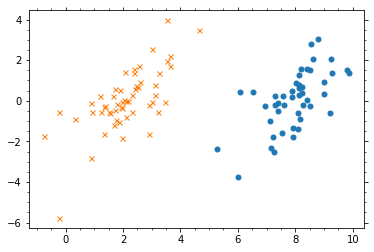

In [5]:
fg1, ax1 = plt.subplots()
ax1.plot(X1[y1>0, 0], X1[y1>0, 1], marker='o', ms=5, ls='None')
ax1.plot(X1[y1<0, 0], X1[y1<0, 1], marker='x', ms=5, ls='None')

In [6]:
"""
基于SMO算法的线性SVC

参考：
1. 机器学习实战, pp.94-105
2. 统计学习方法, pp.128-131
3. Platt1998
"""

inf = float('inf')

class linearSVC:
    """
    Linear SVC
    """
    
    def __init__(self, C=1., tol=1e-3, **kwds):
        """
        Parameters
        -------------
        C : scalar, >0.
            constant to control the regularization
        tol : scalar, >0, default: 1e-3
            tolerence of the fitting
        """
        assert C > 0. and tol > 0.
        self.C_, self.tol_ = C, tol
        self.b_ = 0.
        
        self.support_vectors_ = None
        self.dual_coef_ = None

        self._init_model(**kwds)
        
    def _init_model(self):
        """
        Initialized Parameters
        ------------------------
        w_ : (n, 1) array
            weight vector
        b_ : scalar
            bias
        """
        self.w_, self.b_ = None, 0.
    
    def __call__(self, X):
        """
        evaluate SVC model
        
        Parameters
        -------------
        X : (m', n) array
            input features

        Returns
        ---------
        y_pred : (m', 1)
            predicted labels of input features
        """
        return self.predict(X)

    def predict(self, X):
        """
        Linear SVC model
        
        Parameters
        -------------
        X : (m', n) array
            input features

        Returns
        ---------
        y_pred : (m', 1)
            predicted labels of input features
        """
        assert self.w_ is not None
        return X@self.w_ + self.b_ # np.dot(X, w) + b

    @staticmethod
    def support_vector_indices(alpha):
        """
        Find the indices of support vectors, which satisfies
        \alpha_i != 0. due to the KKT condition.

        Parameters
        -------------
        alpha : (m, 1) array, 0<=alpha<=C
            dual parameters

        Returns
        ---------
        indices : array of non-negative integers
            the index of support vectors in the data
        """
        return np.nonzero(alpha>1.e-7)[0]

    def update_model(self, alpha, X_data, y_data):
        """
        Update the bias and weight terms of the model.
        
        Parameters
        -------------
        alpha : (m, 1) array, 0<=alpha<=C
            dual parameters
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data
        """
        idxs = self.support_vector_indices(alpha)
        X_sv, y_sv = X_data[idxs, :], y_data[idxs, :]
        self.support_vectors_ = X_sv
        self.dual_coef_ = y_sv*alpha[idxs, :]

        self.w_ = (self.dual_coef_*self.support_vectors_).sum(axis=0, keepdims=True).T
        self.b_ = sum(1./y_sv - self.support_vectors_@self.w_) /y_sv.shape[0]

    def eta(self, xi, xj):
        """
        Calculate eta=|| \Phi(xi) - \Phi(xj) ||^2
        """
        return ((xi-xj)**2).sum()
    
    def update_alpha(self, alpha, i, j, X_data, y_data):
        """
        Update the dual parameters based on SMO algorithm

        Parameters
        -------------
        alpha : (m, 1) array, >=0.
            dual parameters
        i, j : integer, >=0, i != j
            the term of alpha needed to be update
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data

        Returns
        ---------
        is_updated : bool
            whether the update is performed
        """
        if i<0 or j<0 or i==j:
            return False

        # calculate errors for i, j
        xi, yi = X_data[i:i+1, :], y_data[i, 0] # xi in (1, n), yi is scalar
        yi_pred = self.predict(xi) # b is canceled out, so here we just use b=0
        Ei = yi_pred - yi

        xj, yj = X_data[j:j+1, :], y_data[j, 0]
        yj_pred = self.predict(xj)
        Ej = yj_pred - yj

        # Compute L, H
        alpha_i, alpha_j = alpha[i, 0], alpha[j, 0]
        if yi*yj < 0:
            L = max(0., alpha_i-alpha_j)
            H = min(self.C_, self.C_+alpha_i-alpha_j)
        else:
            L = max(0., alpha_i+alpha_j-self.C_)
            H = min(self.C_, alpha_i+alpha_j)
        if L >= H:
            #print("[skipped] L >= H")
            return False

        # compute eta
        eta = self.eta(xi, xj)
        if eta <= 0.:
            #print('[skipped] eta <= 0')
            return False # ignored since it rarely happens
        
        # new alphas
        dalpha_i = yi/eta * (Ej - Ei)
        alpha_i_new = np.clip(alpha_i+dalpha_i, a_min=L, a_max=H) # L <= alpha_new <= H
        if abs(alpha_i_new-alpha_i) <= 1e-6*(alpha_i_new + alpha_i + 1e-6):
            #print('[skipped] not enough update for alpha')
            return False
        alpha_j_new = (alpha_i-alpha_i_new)*yi*yj + alpha_j # a1y1 + a2y2 = a'1y1 + a'2y2, |yi|=1

        # update parameters
        alpha[i] = alpha_i_new
        alpha[j] = alpha_j_new
        self.update_model(alpha, X_data, y_data)
        return True
    
    def examine(self, i, alpha, X_data, y_data):
        """
        Do one-step fitting given the first index
        
        Parameters
        -------------
        i : integer, >=0
            the first index
        alpha : (m, 1) array, >=0.
            dual parameters
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data
            
        Returns
        ---------
        is_fitted : bool
        """
        m = X_data.shape[0]
        y_pred = self.predict(X_data)
        
        ai= alpha[i, 0]
        ri = y_data[i, 0]*y_pred[i, 0]-1.
        
        # when KKT condition does not satisfy
        # KKT: 0<a<C, y*y_pred=1; a=0, y*y_pred>=1; a=C, y*y_pred<=1
        if (ai<self.C_ and ri<-self.tol_) or (ai>0 and ri>self.tol_):
            # Heuristic:
            # 1. nonbound points are more likely to be updated, while those
            #    at boundary are kept at the same position
            # 2. dalpha is larger when |E_i - E_j| is larger
            nonbds = set(np.nonzero((alpha>0) & (alpha<self.C_))[0])
            if nonbds:
                errs = y_pred-y_data
                j = np.abs(errs-errs[i]).argmax()
                if self.update_alpha(alpha, i, j, X_data, y_data):
                    return True

            for j in nonbds:
                if self.update_alpha(alpha, i, j, X_data, y_data):
                    return True
                
            for j in range(m):
                if not j in nonbds and self.update_alpha(alpha, i, j, X_data, y_data):
                    return True
        return False

    def _init_fit(self, n):
        """
        Initialize the parameter

        Parameters
        -------------
        n : integer
            number of featurs
        """
        self.w_ = np.zeros((n, 1))

    def fit(self, X_data, y_data):
        """
        Fit the SVC model with SMO algorithm
        
        Parameters
        -------------
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data
            
        Returns
        ---------
        alpha : (m, 1) array, 0<=alpha<=C
            dual parameters
        """
        m, n = X_data.shape
        if y_data.ndim == 1:
            y_data = y_data.reshape((-1, 1))
        alpha = np.zeros((m, 1))
        self._init_fit(n)
        
        it = 0
        num_change = 0
        examine_all = True
        while (num_change>0 or examine_all):
            if examine_all:
                arridx = range(m) # find the points break KKT conditions
            else:
                arridx = np.nonzero((alpha>0)&(alpha<self.C_))[0]

            num_change = 0 # the number of pairs of changed alphas in this pass    
            for i in range(m):
                num_change += self.examine(i, alpha, X_data, y_data)

            if examine_all:
                examine_all = False
            elif num_change == 0:
                examine_all = True

            #print('iter={}, dual={}, loss={}'.format(it, self.dual_gain(), self.loss(X_data, y_data)))
            print('iter={}, dual={}'.format(it, self.dual_gain()))
            it += 1
        return alpha

    def dual_gain(self):
        """
        Calculate only with support vectors
        
        Returns
        --------
        gain : scalar
        """
        # more general case
        #ws = alpha*y_data*X_data
        #return alpha.sum() - 0.5*(ws@ws.T).sum()
        
        # only use support vectors
        ws = self.support_vectors_*self.dual_coef_
        return np.abs(self.dual_coef_).sum() - 0.5*(ws@ws.T).sum()

    def loss(self, X_data, y_data):
        """
        Parameters
        -------------
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data

        Returns
        ---------
        loss : scalar
        """
        y_pred = self.predict(X_data)
        return 0.5*(self.w_**2).sum() + self.C_*np.maximum(0., 1.-y_data*y_pred).sum()

In [7]:
# wrap up all the components
mysvc = linearSVC(C=1., tol=1e-6)
alpha = mysvc.fit(X_data=X1, y_data=y1)

iter=0, dual=0.20880763826924925
iter=1, dual=0.3040758147860484
iter=2, dual=0.3355976134753782
iter=3, dual=0.3405284471119234
iter=4, dual=0.3443164725840272
iter=5, dual=0.3460836455976871
iter=6, dual=0.3469543659708534
iter=7, dual=0.3475793453838718
iter=8, dual=0.34817180827271255
iter=9, dual=0.3487904639015411
iter=10, dual=0.34944330727074224
iter=11, dual=0.35012430900305014
iter=12, dual=0.35082547700232314
iter=13, dual=0.35154020618212967
iter=14, dual=0.35226375960787293
iter=15, dual=0.35299294964655126
iter=16, dual=0.35372570132625947
iter=17, dual=0.35446068894063654
iter=18, dual=0.35519707469917694
iter=19, dual=0.35593433261082574
iter=20, dual=0.35667213375431595
iter=21, dual=0.35741027294470085
iter=22, dual=0.35814862237756473
iter=23, dual=0.3588871025208036
iter=24, dual=0.35962566391044337
iter=25, dual=0.360364275793982
iter=26, dual=0.36110291905635417
iter=27, dual=0.361841581817706
iter=28, dual=0.3625802566954329
iter=29, dual=0.36331893910194113
iter

In [8]:
mysvc.w_, mysvc.b_

(array([[ 0.81439535],
        [-0.27249991]]), array([-3.83784491]))

In [9]:
print('Support Vectors:')
print(mysvc.support_vectors_)
print('y*alpha:')
print(mysvc.dual_coef_)
ax1.plot(mysvc.support_vectors_[:, 0], mysvc.support_vectors_[:, 1],
              ls='None', marker='o', label='support vectors', c='None', mec='k', ms=10)

Support Vectors:
[[ 4.658191  3.507396]
 [ 3.457096 -0.082216]
 [ 6.080573  0.418886]]
y*alpha:
[[-0.12738994]
 [-0.2413584 ]
 [ 0.36874833]]


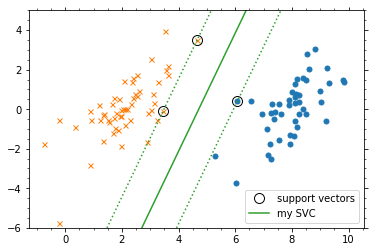

In [10]:
x_ = np.array([0., 10.])
y_ = -(mysvc.b_+ mysvc.w_[0, 0]*x_)/mysvc.w_[1, 0]
y1_ = -(mysvc.b_-1+ mysvc.w_[0, 0]*x_)/mysvc.w_[1, 0]
y2_ = -(mysvc.b_+1+ mysvc.w_[0, 0]*x_)/mysvc.w_[1, 0]
ax1.plot(x_, y_, ls='-', c='C2', label='my SVC')
ax1.plot(x_, y1_, ls=':', c='C2')
ax1.plot(x_, y2_, ls=':', c='C2')

ax1.set_ylim((-6, 5))
ax1.legend()
fg1

#### scikit-learn
`sklearn`中提供了`libsvm`和`liblinear`两个接口用来求解线性SVC问题。前者使用了二次规划方法，时间复杂度在$O(n\,m^2)$到$O(n \, m^3)$之间；而后者专门解决线性SVM问题，时间复杂度为$O(m)$[(scikit-learn.org)](http://scikit-learn.org/stable/modules/svm.html#complexity)。

##### Tips on Practical Use
- **输入的训练集最好是C语言连续的，否则数据会被复制**：Avoiding data copy: For `SVC`, `SVR`, `NuSVC` and `NuSVR`, if the data passed to certain methods is not C-ordered contiguous, and double precision, it will be copied before calling the underlying C implementation. You can check whether a given numpy array is C-contiguous by inspecting its `flags` attribute.
- **对于`LinearSVC`最好用稀疏矩阵的输入**：For `LinearSVC` (and `LogisticRegression`) any input passed as a numpy array will be copied and converted to the liblinear internal sparse data representation (double precision floats and int32 indices of non-zero components). If you want to fit a large-scale linear classifier without copying a dense numpy C-contiguous double precision array as input we suggest to use the `SGDClassifier` class instead. The objective function can be configured to be almost the same as the `LinearSVC` model.
- **设置`C`的值**: `C` is `1` by default and it’s a reasonable default choice. If you have a lot of noisy observations you should decrease it. It corresponds to regularize more the estimation.
- **需要对数据做预处理**：Support Vector Machine algorithms are not scale invariant, *so it is highly recommended to scale your data*. For example, scale each attribute on the input vector `X` to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. See section Preprocessing data for more details on scaling and normalization.
- **关于$\nu$-SVC**：Parameter `nu` ($\nu \in (0, 1]$) in `NuSVC`/`OneClassSVM`/`NuSVR` approximates the fraction of training errors and support vectors. *It can be shown that the $\nu$-SVC formulation is a reparameterization of the C-SVC and therefore mathematically equivalent.*
- **非平衡样本可设权重或者调整`C`**：In SVC, if data for classification are unbalanced (e.g. many positive and few negative), set `class_weight='balanced'` and/or try different penalty parameters `C`.
- **`LinearSVC`具有内部随机性，可用小的`tol`值减小随机**：The underlying LinearSVC implementation uses a random number generator to select features when fitting the model. It is thus not uncommon, to have slightly different results for the same input data. If that happens, try with a smaller tol parameter.
- **使用L1正则化**：Using L1 penalization as provided by `LinearSVC(loss='l2', penalty='l1', dual=False)` yields a sparse solution, i.e. only a subset of feature weights is different from zero and contribute to the decision function. Increasing `C` yields a more complex model (more feature are selected). The `C` value that yields a “null” model (all weights equal to zero) can be calculated using `l1_min_c`.

In [11]:
svc = svm.LinearSVC(C=1., loss='hinge') # liblinear
svc.fit(X1, y1)
print(svc.coef_, svc.intercept_) # w1, w2, b # excuse me?!

[[ 0.48884702 -0.23302346]] [-2.45977747]


In [12]:
svc2 = svm.SVC(kernel='linear') # libsvm
svc2.fit(X1, y1)
print(svc2.coef_, svc2.intercept_) # w1, w2, b

[[ 0.81444269 -0.27274371]] [-3.83775658]


In [13]:
svc2.support_vectors_

array([[ 4.658191,  3.507396],
       [ 3.457096, -0.082216],
       [ 6.080573,  0.418886]])

In [14]:
svc2.dual_coef_

array([[-0.12746518, -0.24133564,  0.36880082]])

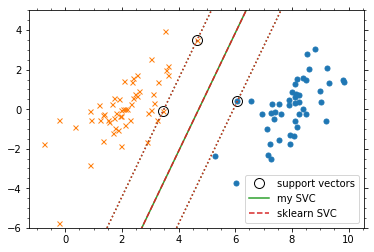

In [15]:
y_ = -(svc2.intercept_+svc2.coef_[0, 0]*x_)/svc2.coef_[0, 1]
y1_ = -(svc2.intercept_-1.+svc2.coef_[0, 0]*x_)/svc2.coef_[0, 1]
y2_ = -(svc2.intercept_+1.+svc2.coef_[0, 0]*x_)/svc2.coef_[0, 1]
ax1.plot(x_, y_, ls='--', c='C3', label='sklearn SVC')
ax1.plot(x_, y1_, ls=':', c='C3')
ax1.plot(x_, y2_, ls=':', c='C3')
ax1.set_ylim((-6, 5))
ax1.legend()
fg1

### 与LR的比较
对于LR，其损失函数为$-[(1+y_i) \ln p_i + (1-y_i) \ln (1-p_i)]/2 =(1-y_i) ({\bf w}^T {\bf x}_i + b) /2 + \ln [ 1+e^{- ({\bf w}^T {\bf x}_i + b)}] = \ln [1+e^{-y_i({\bf w}^T {\bf x}_i + b)}]$，它就是损失函数取成对数损失函数的SVC。  
对于合页损失函数，非支持向量的数据不贡献损失；对于对数损失函数，数据对损失的贡献随着它逐渐远离决策边界而减小。前者在两类数据分界明确时更加有利，因为这样能更有效地给出边界；而当边界不明确时，使用更多远端的数据有利于稳定地计算边界，因此此时后者更好。另外，LR能够给出概率诠释，能够用于多分类任务。

In [16]:
log = linear_model.LogisticRegression(C=1.)
log.fit(X1, y1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

ws=array([[ 0.91467157, -0.39379227]]), b=array([-4.07557876])


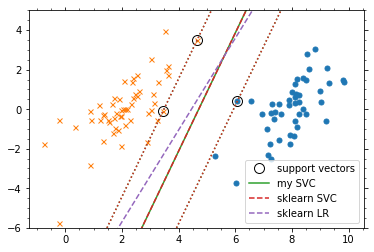

In [17]:
print("ws={!r}, b={!r}".format(log.coef_, log.intercept_))
y3_ = -(log.intercept_+log.coef_[0, 0]*x_)/log.coef_[0, 1]
ax1.plot(x_, y3_, ls='--', c='C4', label='sklearn LR')
ax1.legend()
fg1

## 核SVC
如在[线性回归](1_LinearModel.ipynb#核技巧)中所述：通过使用核函数，我们隐式的在高维特征空间中做线性划分。  
假如我们使用基函数$\{ \phi_i({\bf x})\}$，则软间隔SVC的对偶问题变为：  
$\boxed {\max_{\alpha} \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_i \sum_j \alpha_i \alpha_j y_i y_j \phi({\bf x}_i)^T \phi({\bf x}_j) = \max_{\alpha} \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_i \sum_j \alpha_i \alpha_j y_i y_j K({\bf x}_i, {\bf x}_j)  } $,  
s.t. $\sum_i \alpha_i y_i = 0$, and $0 \leq \alpha_i \leq C$.  

因为强对偶，所以KKT条件成立：  
- stationarity: ${\bf w}=\sum_i \alpha_i y_i \phi({\bf x}_i)$,
- dual feasible: $\alpha_i \geq 0$, and $\mu_i \geq 0$,  
- prime feasible: $1-\xi_i - y_i ({\bf w}^T \phi({\bf x}_i)+b) = 1-\xi_i - y_i (\sum_j \alpha_j y_j K({\bf x}_j, {\bf x}_i)+b) \leq 0$, and $-\xi_i \leq 0$,  
- complementary slackness: $\alpha_i (1-\xi_i-y_i ({\bf w}^T \phi({\bf x}_i)+b))=\alpha_i (1-\xi_i-y_i (\sum_j \alpha_j y_j K({\bf x}_j, {\bf x}_i)+b))=0$, and $\mu_i \xi_i=0$.

进行推断时：  
$\boxed {y = {\bf w}^T \phi({\bf x}) + b = \sum_i \alpha_i y_i K({\bf x}_i, {\bf x}) + b}$

In [18]:
"""
基于SMO算法的核SVC
"""
# Some of the kernels
def rbf(x1, x2, gamma):
    """
    rbf kernel function
    """
    return np.exp(-gamma*((x1-x2)**2).sum(axis=-1))

def linear(x1, x2):
    """
    linear kernel function
    """
    return (x1*x2).sum(axis=-1)

# main class
class kernelSVC(linearSVC):
    """
    Kernelized SVC
    """
    
    support_kernels = {'rbf': rbf, 'linear': linear}

    def __init__(self, kernel='rbf', C=1., tol=1e-3, **kwds):
        """
        Parameters
        -------------
        kernel : string, ='rbf', 'linear', or others
            the kernel adopted
        C : scalar, >0.
            constant to control the regularization
        tol : scalar, >0, default: 1e-3
            tolerence of the fitting
        """
        super().__init__(C=C, tol=tol, kernel=kernel, **kwds)
    
    def _init_model(self, kernel='rbf', **kwds):
        """
        Parameters
        -------------
        kernel : string, ='rbf', 'linear', or function
            the kernel adopted

        Optional Parameters
        -----------------------
        gamma : scalar, >0.
            for rbf kernel, gamma=0.5/sigma**2
        """
        self.kernel_parameters_ = {}
        if kernel in self.support_kernels:
            self.kernel_ = kernel
            kernel_func = self.support_kernels[kernel]
        elif callable(kernel):
            self.kernel_ = kernel.__name__
            kernel_func = kernel
        else:
            raise ValueError('The kernel {} is not support now'.format(kernel))

        for i in range(2, kernel_func.__code__.co_argcount):
            var = kernel_func.__code__.co_varnames[i]
            if var in kwds:
                val = kwds[var]
            else:
                raise TypeError('parameter {} is required'.format(var))
            self.kernel_parameters_[var] = val
        self.kernel_function_ = lambda x1, x2: kernel_func(x1, x2, **self.kernel_parameters_)

    def update_model(self, alpha, X_data, y_data):
        """
        Update the bias and weight terms of the model.
        
        Parameters
        -------------
        alpha : (m, 1) array, 0<=alpha<=C
            dual parameters
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data
        """
        idxs = self.support_vector_indices(alpha)
        X_sv, y_sv = X_data[idxs, :], y_data[idxs, :]
        self.support_vectors_ = X_sv
        self.dual_coef_ = y_sv*alpha[idxs, :]
        
        n_support = len(idxs)
        K = self.kernel_function_(X_sv.reshape(1, n_support, -1), X_sv.reshape(n_support, 1, -1))
        self.b_ = (sum(1./y_sv) - (self.dual_coef_.reshape(1, n_support) *K).sum()) /y_sv.shape[0]

    def predict(self, X):
        """
        kernelized SVC model
        
        Parameters
        -------------
        X : (m', n) array
            input features

        Returns
        ---------
        y_pred : (m', 1)
            predicted labels of input features
        """
        if X.ndim == 1:
            n_sample = 1
        else:
            n_sample = X.shape[0]
        n_support = self.dual_coef_.shape[0]
        #print(n_sample, n_support)
        K = self.kernel_function_(self.support_vectors_.reshape(1, n_support, -1), X.reshape(n_sample, 1, -1))
        y_pred = (self.dual_coef_.reshape(1, n_support) *K).sum(axis=-1, keepdims=True) + self.b_
        #print(y_pred.shape, K.shape)
        return y_pred
    
    def _init_fit(self, n):
        self.dual_coef_ = np.array([[0.]])
        self.support_vectors_ = np.array([[0.]*n])

    def eta(self, xi, xj):
        """
        Calculate eta=|| \Phi(xi) - \Phi(xj) ||^2
        """
        kii = self.kernel_function_(xi, xi)
        kjj = self.kernel_function_(xj, xj)
        kij = self.kernel_function_(xi, xj)
        return kii+kjj-2.*kij

    def dual_gain(self):
        """
        Calculate only with support vectors
        
        Returns
        --------
        gain : scalar
        """
        #print(self.support_vectors_)
        nfeature = self.support_vectors_.shape[-1]
        K = self.kernel_function_(self.support_vectors_.reshape(-1, 1, nfeature), self.support_vectors_.reshape(1, -1, nfeature))
        return np.abs(self.dual_coef_).sum() - 0.5*(self.dual_coef_.reshape(-1, 1)*K*self.dual_coef_.reshape(1, -1)).sum()
    
    def loss(self, X_data, y_data):
        """
        Parameters
        -------------
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data

        Returns
        ---------
        loss : scalar
        """
        nfeature = self.support_vectors_.shape[-1]
        y_pred = self.predict(X_data)
        K = self.kernel_function_(self.support_vectors_.reshape(-1, 1, nfeature), self.support_vectors_.reshape(1, -1, nfeature))
        return 0.5*(self.dual_coef_.reshape(-1, 1)*K*self.dual_coef_.reshape(1, -1)).sum() + \
                    self.C_*np.maximum(0., 1.-y_data*y_pred).sum()

In [19]:
#!head datasets/MLiA/Ch06/testSetRBF2.txt

In [20]:
raw = np.loadtxt('datasets/MLiA/Ch06/testSetRBF2.txt')
X2, y2 = raw[:, :-1], raw[:, -1]

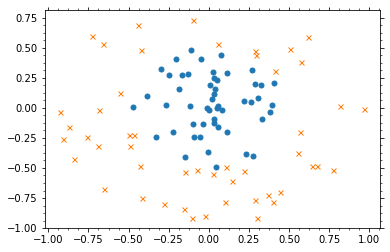

In [21]:
fg2, ax2 = plt.subplots()
ax2.plot(X2[y2>0, 0], X2[y2>0, 1], marker='o', ms=5, ls='None')
ax2.plot(X2[y2<0, 0], X2[y2<0, 1], marker='x', ms=5, ls='None')

In [22]:
mysvc2 = kernelSVC(gamma=1., C=1.)
alpha2 = mysvc2.fit(X2, y2)

iter=0, dual=28.246833540591773
iter=1, dual=32.29520308822113
iter=2, dual=34.3007842275494
iter=3, dual=34.94003913664278
iter=4, dual=35.18092181794687
iter=5, dual=35.27198005313829
iter=6, dual=35.28588882120175
iter=7, dual=35.30820879928412
iter=8, dual=35.33021417840938
iter=9, dual=35.349882195500044
iter=10, dual=35.36883205289229
iter=11, dual=35.38724729389946
iter=12, dual=35.40455233127854
iter=13, dual=35.420363255310264
iter=14, dual=35.434555614943974
iter=15, dual=35.4462957899434
iter=16, dual=35.45377399645051
iter=17, dual=35.459074161049855
iter=18, dual=35.460939348982826
iter=19, dual=35.4609706886898
iter=20, dual=35.46097215351619
iter=21, dual=35.46097292402557
iter=22, dual=35.46097329074104
iter=23, dual=35.46097347452584
iter=24, dual=35.46097356594838
iter=25, dual=35.46097361148095
iter=26, dual=35.46097363415389
iter=27, dual=35.46097364544421
iter=28, dual=35.46097365106637
iter=29, dual=35.460973653866
iter=30, dual=35.46097365530574
iter=31, dual=35.

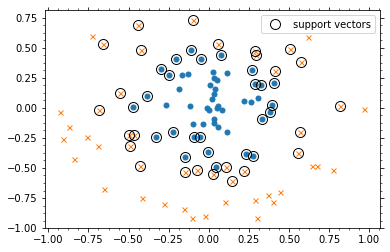

In [23]:
ax2.plot(mysvc2.support_vectors_[:, 0], mysvc2.support_vectors_[:, 1],
              ls='None', marker='o', label='support vectors', c='None', mec='k', ms=10)
ax2.legend()
fg2

#### scikit-learn

##### Tips on Practical Use
- **核缓存大小**：For `SVC`, `SVR`, `nuSVC` and `NuSVR`, the size of the kernel cache has a strong impact on run times for larger problems. If you have enough RAM available, it is recommended to set `cache_size` to a higher value than the default of 200(MB), such as 500(MB) or 1000(MB).

In [24]:
svc3 = svm.SVC(kernel='rbf', gamma=1., C=1.)
svc3.fit(X2, y2)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

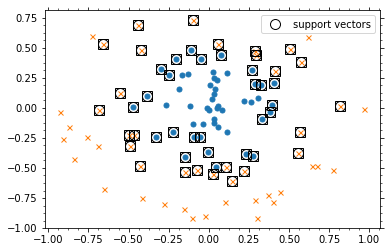

In [25]:
ax2.plot(svc3.support_vectors_[:, 0], svc3.support_vectors_[:, 1],
              ls='None', marker='s', label='support vectors', c='None', mec='k', ms=10)
fg2

Accuracy=94.00%


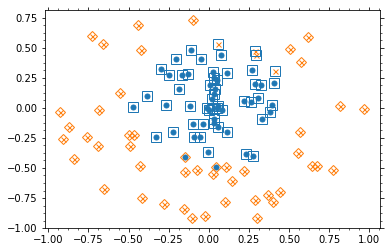

In [26]:
# the predicted labels
fg3, ax3 = plt.subplots()
ax3.plot(X2[y2>0, 0], X2[y2>0, 1], marker='o', ms=5, ls='None', c='C0')
ax3.plot(X2[y2<0, 0], X2[y2<0, 1], marker='x', ms=5, ls='None', c='C1')

#y2_pred = svc3.predict(X2)
y2_pred = mysvc2.predict(X2)[:, 0]
ax3.plot(X2[y2_pred>0, 0], X2[y2_pred>0, 1], marker='s', ms=10, ls='None', c='None', mec='C0')
ax3.plot(X2[y2_pred<0, 0], X2[y2_pred<0, 1], marker='D', ms=7, ls='None', c='None', mec='C1')

print('Accuracy={:.2%}'.format((np.sign(y2_pred)==y2).sum()/len(y2)))

## 支持向量回归(SVR)
SVR假设数据是$y_i = f_{\rm true}(x_i) + noise$的方式生成的。为了避免噪声的影响，它容忍$f({\bf x}_i)$与$y_i$存在最多$\epsilon$的偏差，即只有差别大于$\epsilon$时才计算损失。  
原始问题的优化目标是在损失尽量少且函数在特征空间足够简单，它可以形式化为：
$\min_{{\bf w}, b} \frac{1}{2} \| {\bf w} \|^2 + C \sum_{i=1}^m \ell_\epsilon(f({\bf x}_i) - y_i )$，其中  $\ell_\epsilon(z) = \max(0, |z|-\epsilon)$。

<img src="figures/svr.png" width="65%" height="65%" alt="Smola, 2004, Fig.1" />

引入松弛变量$\xi_i, \eta_i$，使其满足$\xi_i = \max(0, f({\bf x}_i) - y_i -\epsilon)$（或者$\xi_i \geq 0$，$\xi_i \geq f({\bf x}_i)-y_i-\epsilon$），且$\eta_i = \max(0, y_i - f({\bf x}_i) - \epsilon)$（或者$\eta_i \geq 0$，$\eta_i \geq y_i - f({\bf x}_i) - \epsilon$）。  
所以，拉格朗日函数为：$L({\bf w}, b, {\bf \xi}, {\bf \eta}, {\bf \alpha}, {\bf \beta}, {\bf \mu}, {\bf \nu}) = \frac{1}{2} \| {\bf w} \|^2 + C\sum_{i=1}^m (\xi_i + \eta_i) + \sum_{i=1}^m \left [\alpha_i (y_i - f({\bf x}_i) - \epsilon-\xi_i) +\beta_i (f({\bf x}_i)-y_i-\epsilon - \eta_i) - \mu_i \xi_i - \nu_i \eta_i \right ]$，其中$\alpha_i, \beta_i, \mu_i, \nu_i$为拉格朗日乘子，$f({\bf x})={\bf w}^T {\bf x} + b$。

最小化拉格朗日函数的${\bf w}, b, {\bf \xi}, {\bf \eta}$后得到SVR的对偶问题：
$\max_{\alpha, \beta} \sum_{i=1}^m [ (\alpha_i - \beta_i)y_i - (\alpha_i + \beta_i) \epsilon ] - \frac{1}{2} \sum_{i, j=1}^m (\alpha_i - \beta_i) (\alpha_j - \beta_j) {\bf x}_i^T {\bf x}_j$，  
s.t. $\sum_{i=1}^m (\alpha_i - \beta_i) = 0$，$0 \leq \alpha_i, \beta_i \leq C$。

因为强对偶满足KKT条件，所以有：
- stationarity: ${\bf w}=\sum_{i=1}^m (\alpha_i-\beta_i) {\bf x}_i$, $\sum_{i=1}^m (\alpha_i - \beta_i) = 0$, $\alpha_i+\mu_i=C$, and $\beta_i+\nu_i=C$;
- dual feasible: $\alpha_i \geq 0$,  $\beta_i \geq 0$, $\mu_i \geq 0$, and $\nu_i \geq 0$;
- prime feasible: $y_i - {\bf w}^T {\bf x}_i-b - \epsilon-\xi_i \leq 0$, ${\bf w}^T {\bf x}_i+b-y_i-\epsilon - \eta_i \leq 0$, $-\xi_i \leq 0$, and $-\eta_i \leq 0$;
- complementary slackness: $\alpha_i (y_i - {\bf w}^T {\bf x}_i-b - \epsilon-\xi_i) = 0$, $\beta_i ({\bf w}^T {\bf x}_i+b-y_i-\epsilon - \eta_i)=0$, $\mu_i \xi_i =0$, and $\nu_i \eta_i=0$.

由补充松弛性可知，仅当数据点${\bf x}_i$**不**落在以$f({\bf x})$为中心的$2\epsilon$的带子中时，才能有$y_i = f({\bf x}_i)+\epsilon+\xi_i$或$y_i=f({\bf x}_i)-\epsilon-\eta_i$（$\xi_i \geq 0$和$\eta_i \geq 0$）之一成立，$\alpha_i$或$\beta_i$才不会为0，才对拟合有影响。  
另外，当${\bf x}_i$落在带子的边界上时，即$\xi_i=0$或$\eta_i=0$成立时，才能有$\mu_i$或$\nu_i$不为0，此时$\alpha_i$和$\beta_i$中不为0者小于$C$。否则，当落在带子外时，$\alpha_i$和$\beta_i$中不为0者等于$C$。

对于非线性的情况，SVR也可引入核函数进行拟合。

In [27]:
#! head datasets/MLiA/Ch08/ex0.txt

In [28]:
raw3 = np.loadtxt('datasets/MLiA/Ch08/ex0.txt') # Machine Learning in Action, Chap8
X3 = raw3[:, 1:-1] # (1., x_1, x_2, ...) for each vector
y3 = raw3[:, -1:]

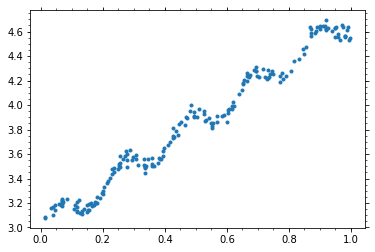

In [29]:
fg4, ax4 = plt.subplots()
ax4.plot(X3[:, 0], y3[:, 0], marker='o', ms=3, ls='None')

### scikit-learn
`svm`模块中的`SVR`类实现了SVR的功能。

In [30]:
# linear model
lin = linear_model.LinearRegression()
lin.fit(X3, y3)

# linear svr
svr = svm.SVR(kernel='linear', epsilon=0.1)
svr.fit(X3, y3)

# kernelized svr
svr2 = svm.SVR(kernel='rbf', gamma=100., epsilon=0.1)
svr2.fit(X3, y3)

/home/szqtc/Softwares/Anaconda/INSTALLED/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=100.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [31]:
print(lin.score(X3, y3))
print(svr.score(X3, y3))
print(svr2.score(X3, y3))

0.9731300889856915
0.9729993320296756
0.9888352381041405


In [32]:
x_pl = np.linspace(0., 1., 100).reshape(-1, 1)
y_pl_lin = lin.predict(x_pl)
y_pl_svr = svr.predict(x_pl)
y_pl_svr2 = svr2.predict(x_pl)

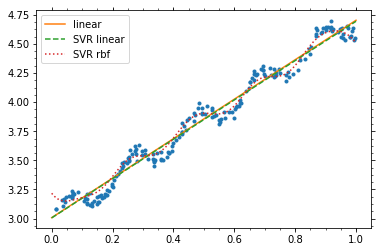

In [33]:
ax4.plot(x_pl.ravel(), y_pl_lin, label='linear')
ax4.plot(x_pl.ravel(), y_pl_svr, ls='--', label='SVR linear')
ax4.plot(x_pl.ravel(), y_pl_svr2, ls=':', label='SVR rbf')
ax4.legend()
fg4

# 参考资料
1. 机器学习, 周志华, pp. 121-139, 403-406.
2. 统计学习方法, 李航, pp. 95-133.
3. 机器学习实战, P. Harrington, pp. 89-113.
4. ISL, G. James, D. Witten, T. Hastie and R. Tibshirani, pp. 356-359.
5. CS229 [convex optimization part2](http://cs229.stanford.edu/section/cs229-cvxopt2.pdf), C. B. Do, pp. 1-13.
6. A Fast Algorithm for Training Support Vector Machines, Platt, 1998.
7. A tutorial on support vector regression, A. J. Smola and B. Scholkopf, 2004.
8. scikit-learn.org, [1.4. SVM](http://scikit-learn.org/stable/modules/svm.html).